# WumpusWorld — Tuned Entropy‑Regularized Soft Actor (Discrete)

**Goal:** Improve **success rate**, reduce **death rate**, and drive **entropy** lower/more stable.

### What’s changed vs. previous notebook
1. **Auto‑tuned temperature (α):** replaces fixed α. We set a **target entropy** and learn α so the policy entropy trends toward that target → steadier, lower final entropy.
2. **Longer training & bigger batches:** `episodes=600`, `batch_size=256`, `warmup_steps=800` for better convergence.
3. **Stability tweaks:** gradient clipping (`max_norm=1.0`), slightly larger `tau=0.01` for faster target updates.
4. **Evaluations & plots:** success/death/timeout rates, entropy trajectory, returns, losses, action frequencies, and a greedy‑policy evaluation/heatmap.


In [1]:

import math
import random
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## WumpusWorld Environment (with terminal reasons)

In [2]:

class WumpusWorldEnv:
    def __init__(self, size=4, max_steps=50, seed=0):
        self.size = size
        self.max_steps = max_steps
        self.rng = random.Random(seed)
        self.start = (0,0)
        self.gold = (size-1, size-1)
        self.pit = (1,1)
        self.wumpus = (2,2)
        self.action_space_n = 4
        self.observation_dim = self.size * self.size
        self.reset()

    def reset(self):
        self.agent = tuple(self.start)
        self.steps = 0
        return self._obs()

    def _obs(self):
        obs = np.zeros(self.size*self.size, dtype=np.float32)
        idx = self.agent[0]*self.size + self.agent[1]
        obs[idx] = 1.0
        return obs

    def step(self, action):
        self.steps += 1
        r, c = self.agent
        if action == 0:    # up
            r = max(0, r-1)
        elif action == 1:  # right
            c = min(self.size-1, c+1)
        elif action == 2:  # down
            r = min(self.size-1, r+1)
        elif action == 3:  # left
            c = max(0, c-1)
        self.agent = (r, c)

        reward = -0.01
        done = False
        info = {"terminal": None}
        if self.agent == self.gold:
            reward = 10.0
            done = True
            info["terminal"] = "gold"
        elif self.agent == self.pit:
            reward = -10.0
            done = True
            info["terminal"] = "pit"
        elif self.agent == self.wumpus:
            reward = -10.0
            done = True
            info["terminal"] = "wumpus"
        elif self.steps >= self.max_steps:
            done = True
            info["terminal"] = "timeout"

        return self._obs(), reward, done, info

    def sample_action(self):
        return self.rng.randrange(4)


## Replay Buffer

In [3]:

Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        import random
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)


## Networks

In [4]:

class DiscreteActor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, state):
        return self.net(state)  # logits

class CriticQ(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, state):
        return self.net(state)  # Q(s, a) for all actions


## Utils

In [5]:

def soft_update(target, source, tau=0.005):
    for targ, src in zip(target.parameters(), source.parameters()):
        targ.data.copy_(targ.data * (1.0 - tau) + src.data * tau)

def moving_average(x, k=20):
    if len(x) == 0:
        return np.array([])
    x = np.array(x, dtype=np.float32)
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    k = min(k, len(x))
    return (cumsum[k:] - cumsum[:-k]) / float(k)


## Training (auto‑tuned α, success/death/timeout tracking, gradient clipping)

In [6]:

def train_soft_actor_discrete_tuned(
    env,
    episodes=600,
    warmup_steps=800,
    batch_size=256,
    gamma=0.99,
    init_alpha=0.05,      # initial alpha (will be auto-tuned)
    target_entropy=0.7,   # desired policy entropy (nats); for 4 actions max is ~1.386
    actor_lr=3e-4,
    critic_lr=3e-4,
    alpha_lr=1e-3,
    tau=0.01,
    max_grad_norm=1.0,
    seed=0,
):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    state_dim = env.observation_dim
    action_dim = env.action_space_n

    actor = DiscreteActor(state_dim, action_dim).to(device)
    critic1 = CriticQ(state_dim, action_dim).to(device)
    critic2 = CriticQ(state_dim, action_dim).to(device)
    target1 = CriticQ(state_dim, action_dim).to(device)
    target2 = CriticQ(state_dim, action_dim).to(device)
    target1.load_state_dict(critic1.state_dict())
    target2.load_state_dict(critic2.state_dict())

    actor_optim = optim.Adam(actor.parameters(), lr=actor_lr)
    critic1_optim = optim.Adam(critic1.parameters(), lr=critic_lr)
    critic2_optim = optim.Adam(critic2.parameters(), lr=critic_lr)

    # Auto-tuned alpha (temperature)
    log_alpha = torch.tensor(np.log(init_alpha), dtype=torch.float32, device=device, requires_grad=True)
    alpha_opt = optim.Adam([log_alpha], lr=alpha_lr)

    buffer = ReplayBuffer(100000)

    # Logs
    ep_returns, ep_lengths = [], []
    actor_loss_hist, critic1_loss_hist, critic2_loss_hist = [], [], []
    entropy_hist, soft_value_hist, alpha_hist = [], [], []
    action_freqs_per_ep = []
    ep_terminal = []

    def select_action(state, greedy=False):
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        logits = actor(s)
        if greedy:
            return logits.argmax(dim=1).item(), logits
        dist = torch.distributions.Categorical(logits=logits)
        return dist.sample().item(), logits

    # Warmup with random policy
    s = env.reset()
    for _ in range(warmup_steps):
        a = env.sample_action()
        ns, r, d, _info = env.step(a)
        buffer.push(s, a, r, ns, float(d))
        s = ns if not d else env.reset()

    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        done = False
        steps = 0
        action_counts = np.zeros(env.action_space_n, dtype=np.int32)
        terminal_cause = None

        while not done:
            a, _ = select_action(s, greedy=False)
            ns, r, d, info = env.step(a)
            buffer.push(s, a, r, ns, float(d))
            s = ns
            total_r += r
            done = d
            steps += 1
            action_counts[a] += 1
            if done:
                terminal_cause = info.get("terminal", None)

            # Learn
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
                actions = torch.tensor(batch.action, dtype=torch.int64, device=device).view(-1,1)
                rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).view(-1,1)
                next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
                dones = torch.tensor(batch.done, dtype=torch.float32, device=device).view(-1,1)

                # ----- Critics update -----
                with torch.no_grad():
                    next_logits = actor(next_states)
                    next_dist = torch.distributions.Categorical(logits=next_logits)
                    next_probs = next_dist.probs
                    next_log_probs = torch.log(next_probs + 1e-8)

                    t1 = target1(next_states)
                    t2 = target2(next_states)
                    tmin = torch.min(t1, t2)

                    alpha = log_alpha.exp()
                    soft_v_next = (next_probs * (tmin - alpha * next_log_probs)).sum(dim=1, keepdim=True)
                    y = rewards + (1.0 - dones) * gamma * soft_v_next

                q1 = critic1(states).gather(1, actions)
                q2 = critic2(states).gather(1, actions)

                c1_loss = F.mse_loss(q1, y)
                c2_loss = F.mse_loss(q2, y)

                critic1_optim.zero_grad()
                c1_loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(critic1.parameters(), max_grad_norm)
                critic1_optim.step()

                critic2_optim.zero_grad()
                c2_loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(critic2.parameters(), max_grad_norm)
                critic2_optim.step()

                # ----- Actor update -----
                logits = actor(states)
                dist = torch.distributions.Categorical(logits=logits)
                probs = dist.probs
                log_probs = torch.log(probs + 1e-8)
                entropy = dist.entropy().mean().item()
                entropy_hist.append(entropy)

                q1_pi = critic1(states)
                q2_pi = critic2(states)
                qmin_pi = torch.min(q1_pi, q2_pi)

                alpha = log_alpha.exp()
                actor_loss = (probs * (alpha * log_probs - qmin_pi)).sum(dim=1).mean()

                actor_optim.zero_grad()
                actor_loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
                actor_optim.step()

                # ----- Temperature (alpha) auto‑tuning -----
                # Drive entropy toward target_entropy
                # Use the *current* entropy estimate (no grad through entropy into alpha target)
                entropy_batch = dist.entropy().detach()
                alpha_loss = -(log_alpha * (entropy_batch - target_entropy)).mean()

                alpha_opt.zero_grad()
                alpha_loss.backward()
                alpha_opt.step()
                alpha_hist.append(log_alpha.exp().item())

                # ----- Targets -----
                soft_update(target1, critic1, tau)
                soft_update(target2, critic2, tau)

                with torch.no_grad():
                    soft_v = (probs * (qmin_pi - alpha * log_probs)).sum(dim=1).mean().item()
                    soft_value_hist.append(soft_v)

                actor_loss_hist.append(actor_loss.item())
                critic1_loss_hist.append(c1_loss.item())
                critic2_loss_hist.append(c2_loss.item())

        ep_returns.append(total_r)
        ep_lengths.append(steps)
        ep_terminal.append(terminal_cause or "timeout")
        action_freqs_per_ep.append(action_counts / max(1, action_counts.sum()))

        if (ep+1) % max(1, episodes//10) == 0:
            print(f"Episode {ep+1}/{episodes} | Return {total_r:.2f} | Steps {steps} | End: {terminal_cause} | Entropy~{entropy_hist[-1]:.3f} | alpha~{alpha_hist[-1]:.4f}")

    logs = {
        "returns": ep_returns,
        "lengths": ep_lengths,
        "actor_loss": actor_loss_hist,
        "critic1_loss": critic1_loss_hist,
        "critic2_loss": critic2_loss_hist,
        "entropy": entropy_hist,
        "soft_value": soft_value_hist,
        "alpha": alpha_hist,
        "action_freqs": action_freqs_per_ep,
        "terminal": ep_terminal,
        "target_entropy": target_entropy,
    }
    models = {"actor": actor, "critic1": critic1, "critic2": critic2}
    return models, logs


## Train (Tuned)

In [7]:

env = WumpusWorldEnv(size=4, max_steps=50, seed=42)
models, logs = train_soft_actor_discrete_tuned(
    env=env,
    episodes=600,
    warmup_steps=800,
    batch_size=256,
    gamma=0.99,
    init_alpha=0.05,
    target_entropy=0.7,   # ~50% of log(4)=1.386 for a more decisive policy
    actor_lr=3e-4,
    critic_lr=3e-4,
    alpha_lr=1e-3,
    tau=0.01,
    max_grad_norm=1.0,
    seed=21
)
print("Training complete.")


Episode 60/600 | Return -0.50 | Steps 50 | End: timeout | Entropy~1.250 | alpha~0.3957
Episode 120/600 | Return -0.50 | Steps 50 | End: timeout | Entropy~1.266 | alpha~8.9122
Episode 180/600 | Return -0.50 | Steps 50 | End: timeout | Entropy~1.260 | alpha~177.6704
Episode 240/600 | Return -10.11 | Steps 12 | End: pit | Entropy~1.303 | alpha~2511.4827
Episode 300/600 | Return -10.14 | Steps 15 | End: pit | Entropy~1.319 | alpha~13795.5010
Episode 360/600 | Return -10.33 | Steps 34 | End: pit | Entropy~1.328 | alpha~41535.8281
Episode 420/600 | Return -10.05 | Steps 6 | End: pit | Entropy~1.349 | alpha~102638.4688
Episode 480/600 | Return -10.03 | Steps 4 | End: pit | Entropy~1.365 | alpha~206478.6406
Episode 540/600 | Return -10.31 | Steps 32 | End: pit | Entropy~1.376 | alpha~428531.9375
Episode 600/600 | Return -10.04 | Steps 5 | End: pit | Entropy~1.382 | alpha~815697.0000
Training complete.


## Success, Death, Timeout Rates

Final Success Rate: 1.33%
Final Death Rate:   58.33%
Final Timeout Rate: 40.33%


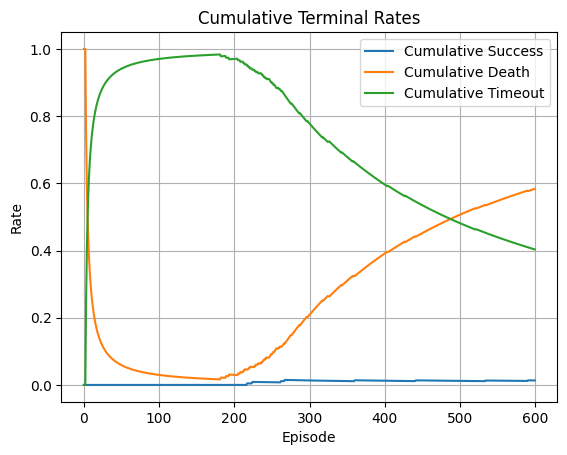

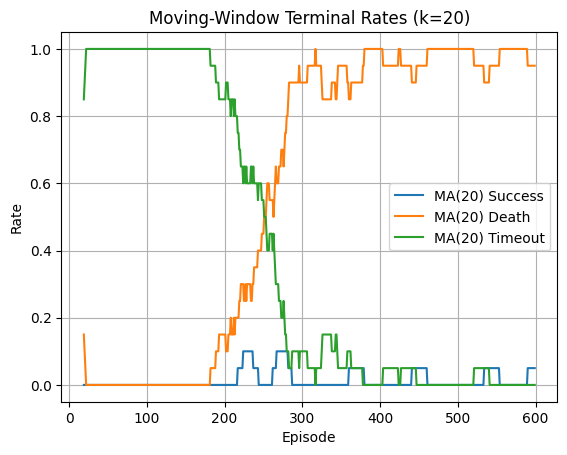

In [8]:

terms = logs["terminal"]
success_flags = np.array([1 if t == "gold" else 0 for t in terms], dtype=np.int32)
death_flags = np.array([1 if t in ("pit","wumpus") else 0 for t in terms], dtype=np.int32)
timeout_flags = np.array([1 if t == "timeout" else 0 for t in terms], dtype=np.int32)

cum_success_rate = np.cumsum(success_flags) / np.arange(1, len(success_flags)+1)
cum_death_rate = np.cumsum(death_flags) / np.arange(1, len(death_flags)+1)
cum_timeout_rate = np.cumsum(timeout_flags) / np.arange(1, len(timeout_flags)+1)

def moving_rate(flags, k=20):
    flags = flags.astype(np.float32)
    if len(flags) < 1:
        return np.array([])
    csum = np.cumsum(np.insert(flags, 0, 0.0))
    if len(flags) < k:
        k = len(flags)
    return (csum[k:] - csum[:-k]) / float(k)

ma_success = moving_rate(success_flags, 20)
ma_death = moving_rate(death_flags, 20)
ma_timeout = moving_rate(timeout_flags, 20)

print(f"Final Success Rate: {cum_success_rate[-1]*100:.2f}%")
print(f"Final Death Rate:   {cum_death_rate[-1]*100:.2f}%")
print(f"Final Timeout Rate: {cum_timeout_rate[-1]*100:.2f}%")

plt.figure()
plt.plot(cum_success_rate, label="Cumulative Success")
plt.plot(cum_death_rate, label="Cumulative Death")
plt.plot(cum_timeout_rate, label="Cumulative Timeout")
plt.title("Cumulative Terminal Rates")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
if len(ma_success) > 0: plt.plot(range(19, 19+len(ma_success)), ma_success, label="MA(20) Success")
if len(ma_death) > 0: plt.plot(range(19, 19+len(ma_death)), ma_death, label="MA(20) Death")
if len(ma_timeout) > 0: plt.plot(range(19, 19+len(ma_timeout)), ma_timeout, label="MA(20) Timeout")
plt.title("Moving-Window Terminal Rates (k=20)")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()


## Learning Curves & Temperature

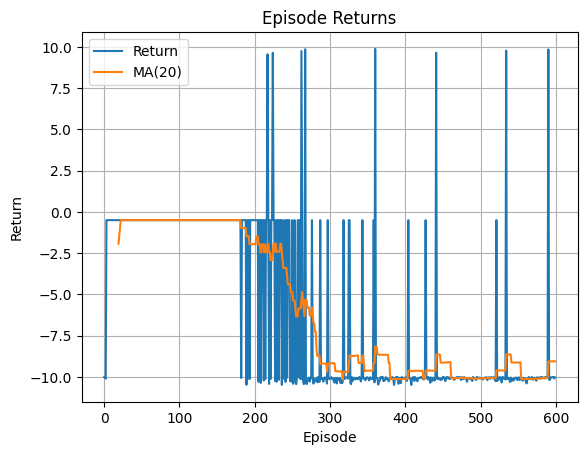

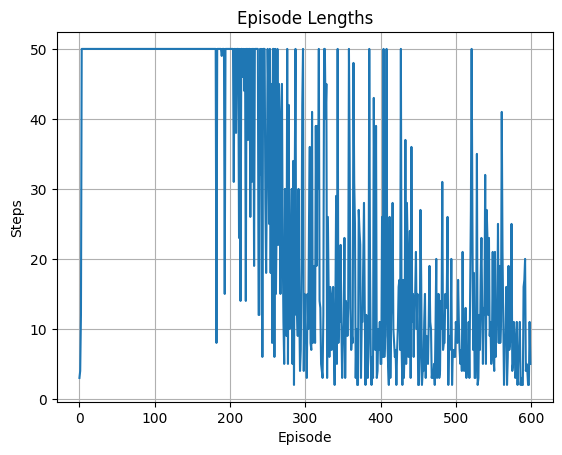

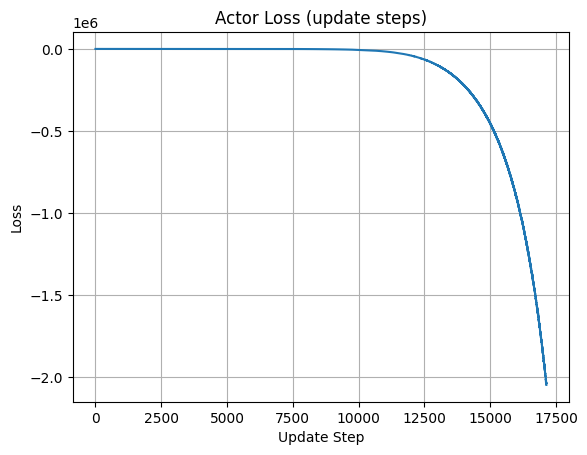

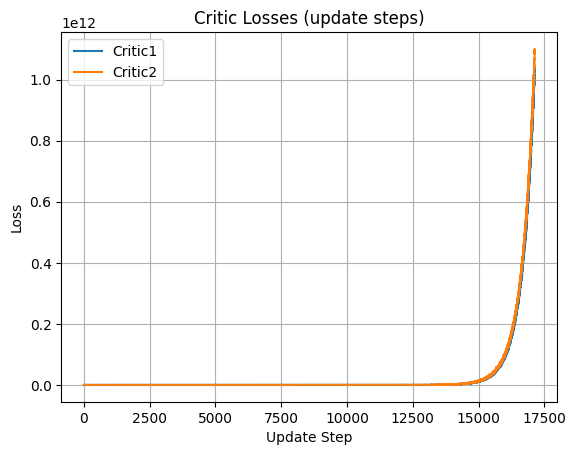

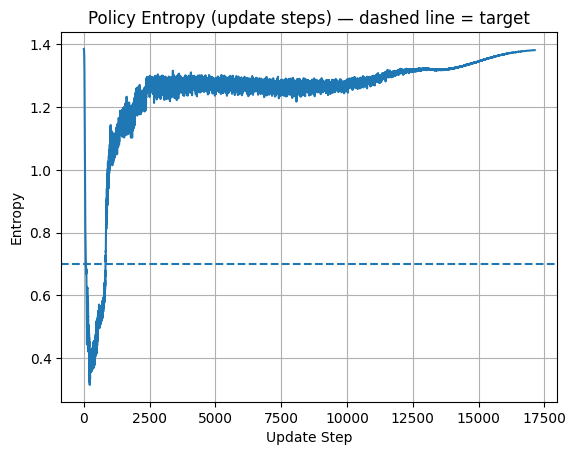

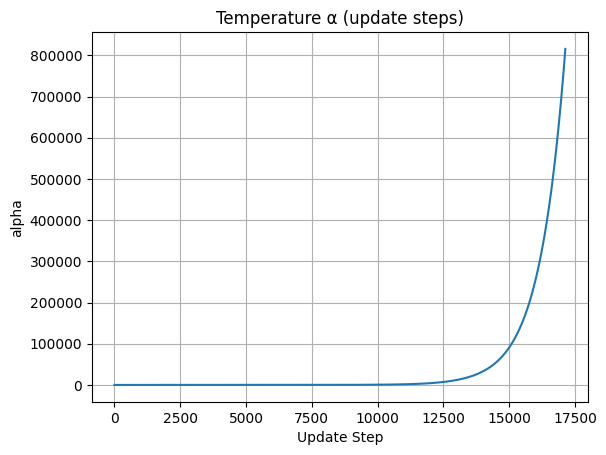

In [9]:

plt.figure()
plt.plot(logs["returns"], label="Return")
ma = moving_average(logs["returns"], k=20)
if len(ma) > 0:
    plt.plot(range(19, 19+len(ma)), ma, label="MA(20)")
plt.title("Episode Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(logs["lengths"])
plt.title("Episode Lengths")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(logs["actor_loss"])
plt.title("Actor Loss (update steps)")
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(logs["critic1_loss"], label="Critic1")
plt.plot(logs["critic2_loss"], label="Critic2")
plt.title("Critic Losses (update steps)")
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(logs["entropy"])
plt.axhline(y=logs["target_entropy"], linestyle="--")
plt.title("Policy Entropy (update steps) — dashed line = target")
plt.xlabel("Update Step")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(logs["alpha"])
plt.title("Temperature α (update steps)")
plt.xlabel("Update Step")
plt.ylabel("alpha")
plt.grid(True)
plt.show()


## Action Frequencies (per episode)

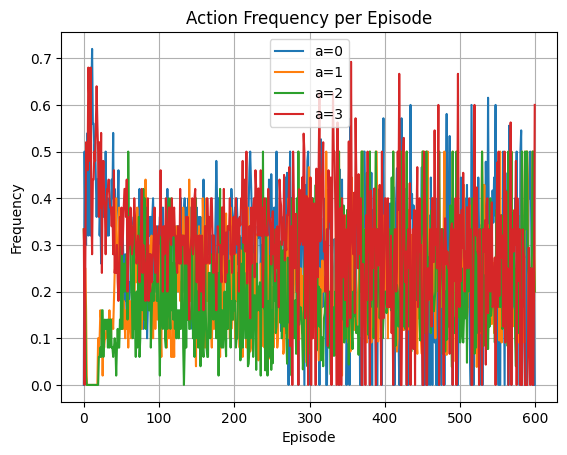

In [10]:

freqs = np.vstack(logs["action_freqs"])
for a in range(freqs.shape[1]):
    plt.plot(freqs[:, a], label=f"a={a}")
plt.title("Action Frequency per Episode")
plt.xlabel("Episode")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
